In [1]:
import argparse
import random
import sys

sys.path.append("../") 
from utils import *
from model import *
import numpy as np 
import scipy.sparse as sp
import os
from batch_visualization import *

In [2]:
parser = argparse.ArgumentParser()


parser.add_argument("--learning_rate", type=float, default=1e-3, help='Learning rate.')
parser.add_argument("--num_hidden", type=int, default=128, help='Hidden dimension.')
parser.add_argument("--num_proj_hidden", type=int, default=128, help='num_proj_hidden dimension.')
parser.add_argument("--activation", type=str, default='relu', help='activation function')
parser.add_argument("--num_layers", type=int, default=2, help='num layers.')
parser.add_argument("--num_protos", type=int, default=3, help='num of prototypes')
parser.add_argument("--num_changed_edges", type=int, default=50, help='num of added/removed edges')
parser.add_argument("--topology_denoising", type=bool, default=False, help='if scPROTEIN uses topology denoising')
parser.add_argument("--attribute_denoising", type=bool, default=False, help='if scPROTEIN uses topology denoising')
parser.add_argument("--drop_edge_rate_1", type=float, default=0., help='drop_edge_rate_1')  
parser.add_argument("--drop_edge_rate_2", type=float, default=0.1, help='drop_edge_rate_2')   
parser.add_argument("--drop_feature_rate_1", type=float, default=0.1, help='drop_feature_rate_1')  
parser.add_argument("--drop_feature_rate_2", type=float, default=0., help='drop_feature_rate_2') 
parser.add_argument("--threshold", type=float, default=0.05, help='threshold of graph construct')  
parser.add_argument("--tau", type=float, default=0.4, help='tau')
parser.add_argument("--weight_decay", type=float, default=0., help='weight_decay')
parser.add_argument("--num_epochs", type=int, default=200, help='Number of epochs.')
parser.add_argument("--seed", type=int, default=777, help='Random seed.')   #666
parser.add_argument("--alpha", type=float, default=0.05, help='balance factor')
parser.add_argument("--feature_preprocess", type=bool, default=False, help='feature preprocess')

args =parser.parse_known_args()[0]  

setup_seed(args.seed)
activation = nn.PReLU() if args.activation == 'prelu' else F.relu


In [3]:
batch_label,cell_type_with_dataname,cell_type_label,overlap_cell_type_label, features = integrate_sc_proteomic_features('pSCoPE_Leduc','SCoPE2_Leduc')

overlap celltype: ['U-937']
overlap protein nums: 1000


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()
data = graph_generation(features, args.threshold, args.feature_preprocess).to(device)

encoder = Encoder(data.num_features, args.num_hidden, activation, k=args.num_layers).to(device)
model = Model(encoder, args.num_hidden, args.num_proj_hidden, args.tau).to(device)

scPROTEIN = scPROTEIN_learning(model,device, data, args.drop_feature_rate_1,args.drop_feature_rate_2,args.drop_edge_rate_1,args.drop_edge_rate_2,
                 args.learning_rate, args.weight_decay, args.num_protos, args.topology_denoising, args.num_epochs, args.alpha, args.num_changed_edges,args.seed)


In [5]:
scPROTEIN.train()

(T) | Epoch=001, loss=8.0666 
(T) | Epoch=002, loss=7.6740 
(T) | Epoch=003, loss=7.4940 
(T) | Epoch=004, loss=7.4495 
(T) | Epoch=005, loss=7.4415 
(T) | Epoch=006, loss=7.4406 
(T) | Epoch=007, loss=7.4411 
(T) | Epoch=008, loss=7.4390 
(T) | Epoch=009, loss=7.4355 
(T) | Epoch=010, loss=7.4318 
(T) | Epoch=011, loss=7.4263 
(T) | Epoch=012, loss=7.4204 
(T) | Epoch=013, loss=7.4127 
(T) | Epoch=014, loss=7.4039 
(T) | Epoch=015, loss=7.3933 
(T) | Epoch=016, loss=7.3789 
(T) | Epoch=017, loss=7.3589 
(T) | Epoch=018, loss=7.3269 
(T) | Epoch=019, loss=7.2744 
(T) | Epoch=020, loss=7.1859 
(T) | Epoch=021, loss=7.0710 
(T) | Epoch=022, loss=7.0297 
(T) | Epoch=023, loss=6.9399 
(T) | Epoch=024, loss=6.9440 
(T) | Epoch=025, loss=6.8873 
(T) | Epoch=026, loss=6.8827 
(T) | Epoch=027, loss=6.8801 
(T) | Epoch=028, loss=6.8040 
(T) | Epoch=029, loss=6.8573 
(T) | Epoch=030, loss=6.8352 
(T) | Epoch=031, loss=6.8074 
(T) | Epoch=032, loss=6.7655 
(T) | Epoch=033, loss=6.7471 
(T) | Epoc

In [6]:
embedding = scPROTEIN.embedding_generation()
np.save('embedding_scope_pscope_leduc.npy',embedding)

In [7]:
celltype_clus(embedding,cell_type_label)

,ASW,ARI,NMI,PS
0,0.293,0.607,0.624,0.918


In [8]:
batch_clus(embedding,cell_type_label,batch_label,overlap_cell_type_label)

,1-ASW,1-ARI,1-NMI,1-PS
0,0.869,1.052,0.947,0.081


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

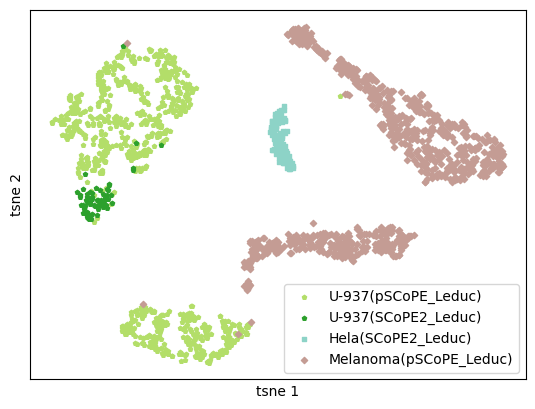

In [9]:
integration_visualization(cell_type_with_dataname,embedding)